# Media Matters Worldwide Bayesian Media Mix Model Template

This notebook contains a media mix model, created from methods similar to __[this paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf)__. The model informs a budget optimizer, which optimizes the budget for spending in advertising media channels in the short-term.

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt
from functools import reduce
from yellowbrick.regressor import residuals_plot
from transformations import transform_one_column, select_best_feature, feature_imp_random_forest

import time
import datetime
import ipywidgets as widgets
from ipywidgets import FileUpload

from IPython.display import display
from IPython.display import FileLink
import io
import re
from scipy.optimize import minimize, LinearConstraint

import openpyxl
import xlrd

import holidays

# import panel as pn
# pn.extension()

from helper import *
from bayesian import *

import arviz as az

# Data Collection

### your inputs start

In [3]:
client = "Proactiv" # name of the client
use_excel = True # true corresponds to files are excel files, or .xlsx | false corresponds to .csv
granularity = True # true corresponds to daily 
data_type = "SALES DATA" # leave unchanged
sales_fileName = "./../Proactiv_OrderData_2022.03.23.xlsx" # file name of the sales data
ad_fileName = "./../Proactiv_MediaData_2022.03.23.xlsx" # file name of the advertising/media mix data

### your inputs end

In [4]:
sales_df_cleaned = read_sales_data(sales_fileName, use_excel, data_type, granularity)

COLUMNS of SALES DATA: ['Campaign Geo' 'Day' 'Visits' 'Orders' 'Conv Rate (Adobe)'
 'Revenue (Adobe)']


COUNTRY | [column-name/NONE] Campaign Geo
DAY | [column-name] Day
RESPONSE VARIABLE | [column-name] Orders


This process will be repeated for the advertising media mix data.

In [5]:
ad_df, data_dict = read_ad_data(ad_fileName, sales_df_cleaned, use_excel)

['Day' 'Campaign Geo' 'Channel' 'Publisher' 'Media Objective' 'Audience'
 'Ad Type' 'Media Cost' 'Impressions']


COUNTRY | [column-name/NONE] Campaign Geo
MEDIA COST | [column-name/NONE] Media Cost
IMPRESSIONS | [column-name/NONE] Impressions


***

# Modeling

### your inputs start

In [6]:
country = "US" # specify country name, must be consistent with sales/ad dataset
target = 'Orders' # target variable specified above
combine_columns = True # true if you wish to combine too-granular columns, false if leave data as is

### your inputs end

In [86]:
df = read_data_from_data_dict(data_dict, country, target, combine_columns=True)

In [87]:
df = df[["amazon_media_cost", "facebook_media_cost", "youtube_media_cost", "googlesearch_media_cost", "dv360_media_cost", f"{target}"]]
initial_model = BayesianMixModel(country=country, target=target)
X, y = df.drop(columns=[target]), df[target]
xtrain, xval, ytrain, yval = train_test_split(X,y, test_size=0.1, shuffle=False)

In [88]:
initial_model.fit(xtrain, ytrain, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef, noise, base, car_dv360_media_cost, sat_dv360_media_cost, coef_dv360_media_cost, car_googlesearch_media_cost, sat_googlesearch_media_cost, coef_googlesearch_media_cost, car_youtube_media_cost, sat_youtube_media_cost, coef_youtube_media_cost, car_facebook_media_cost, sat_facebook_media_cost, coef_facebook_media_cost, car_amazon_media_cost, sat_amazon_media_cost, coef_amazon_media_cost]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 322 seconds.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 458 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5823052560182241, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [89]:
train_mape, val_mape = calculate_mape(initial_model, xtrain, ytrain, xval, yval)
print(f"TRAIN MEAN ABSOLUTE PERCENTAGE ERROR = {train_mape}")
print(f"VALIDATION MEAN ABSOLUTE PERCENTAGE ERROR = {val_mape}")

TRAIN MEAN ABSOLUTE PERCENTAGE ERROR = 0.16693952303809678
VALIDATION MEAN ABSOLUTE PERCENTAGE ERROR = 0.23244099540103755


training plots

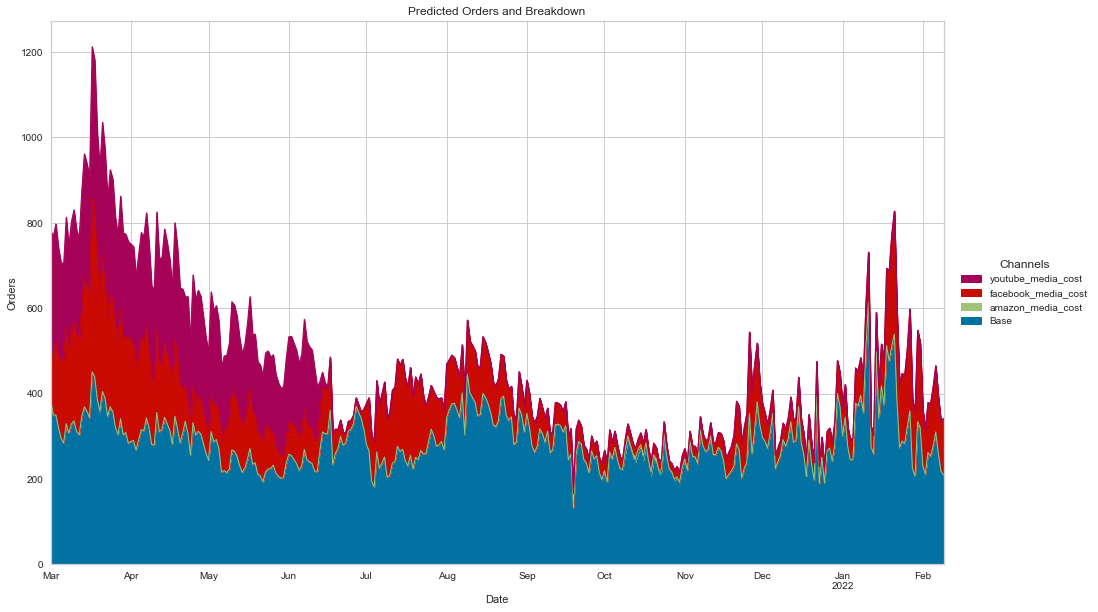

In [10]:
initial_model.attribution()

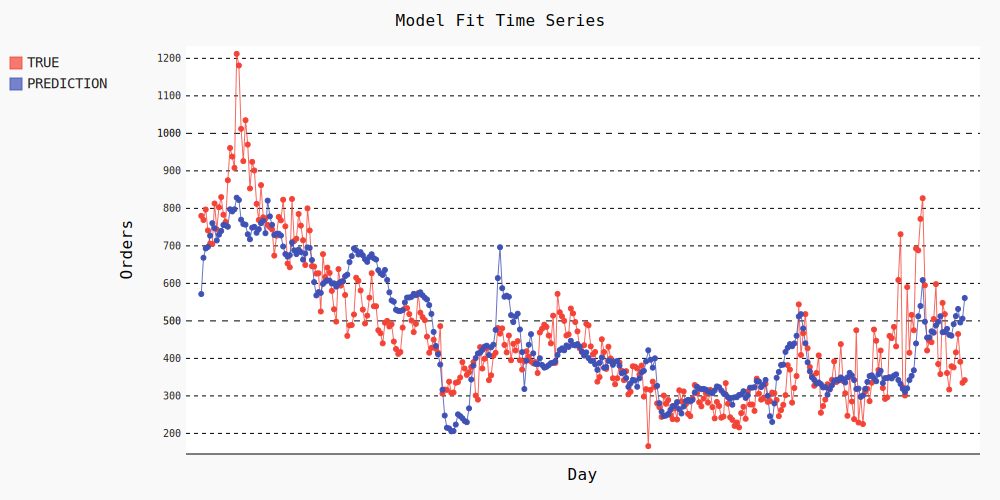

In [91]:
initial_model.lineplot()

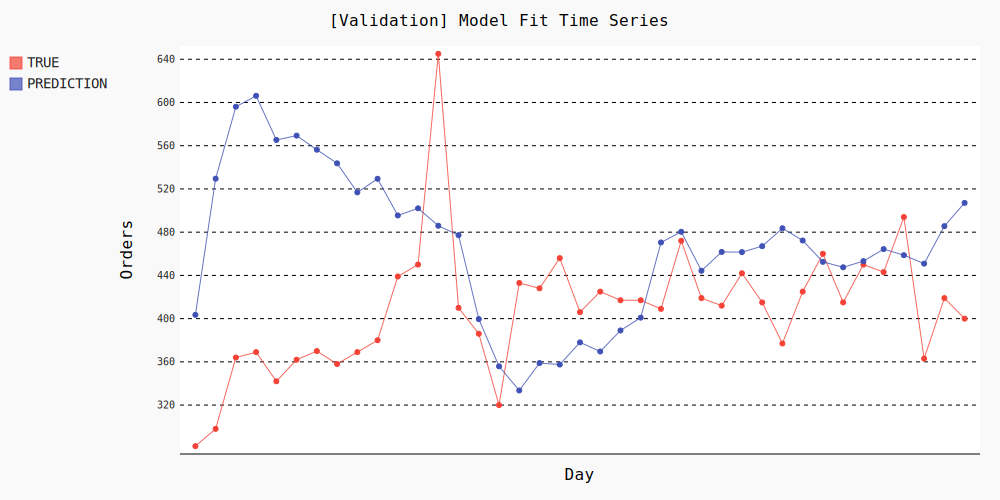

In [92]:
validation_lineplot(initial_model, xval, yval, target)

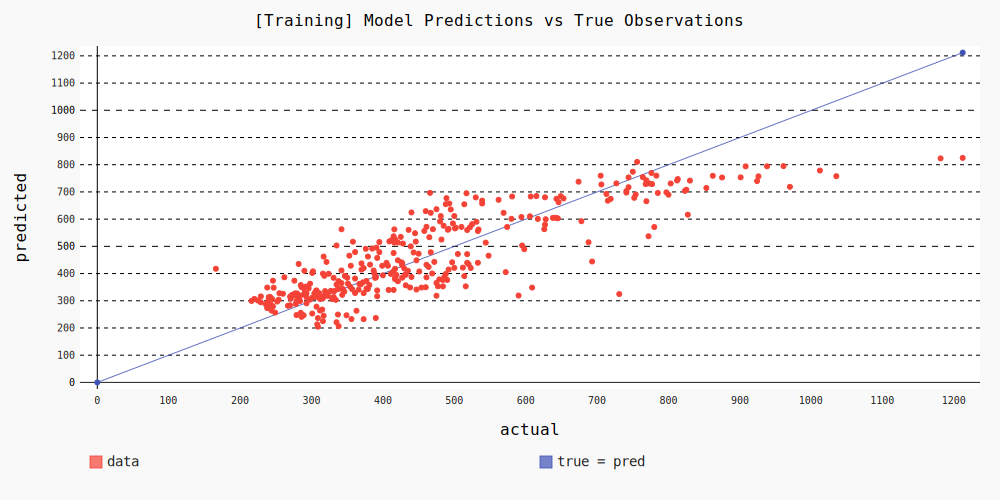

In [93]:
initial_model.scatterplot()

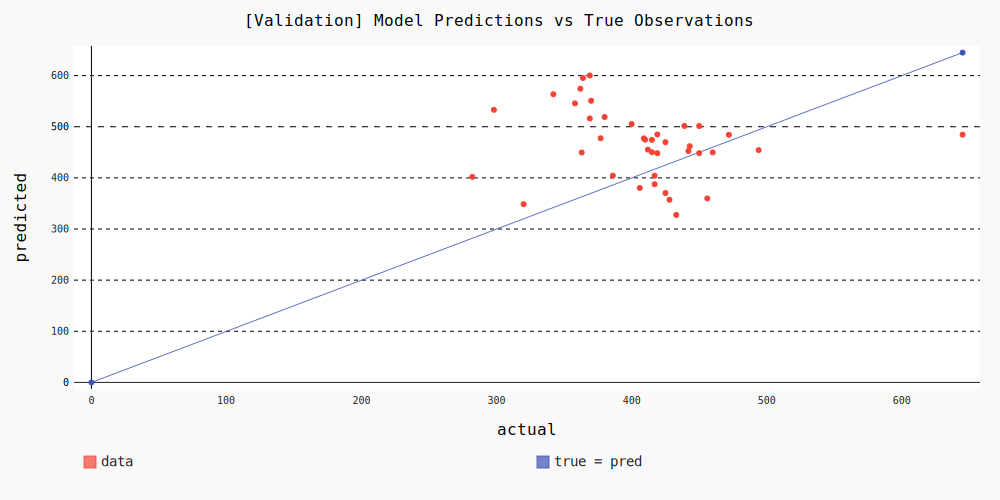

In [94]:
validation_scatterplot(initial_model, xval, yval)

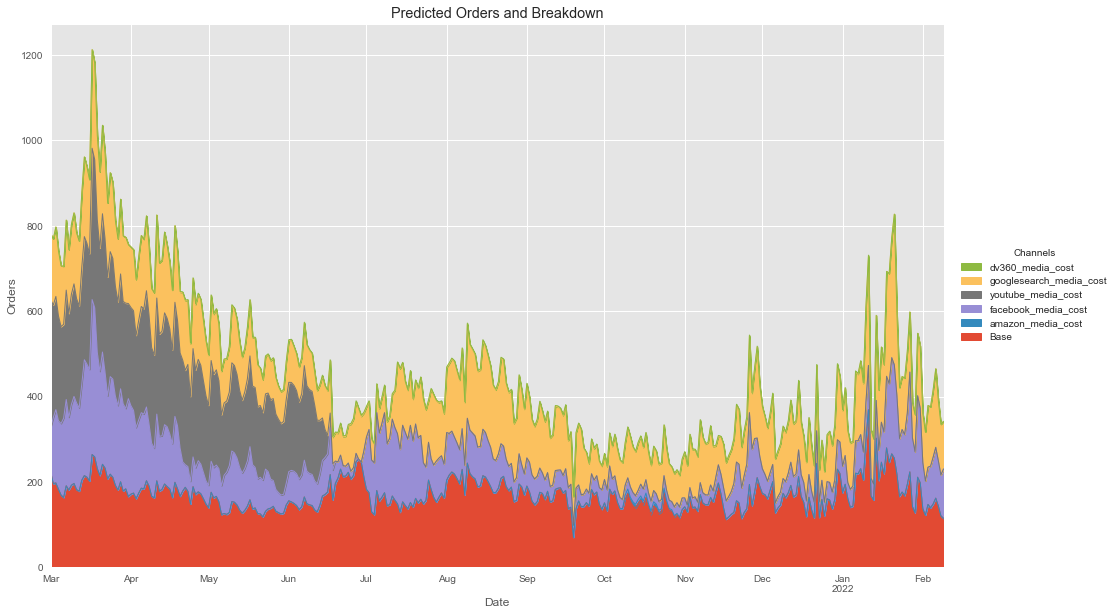

In [95]:
initial_model.attribution()

In [21]:
saturation_curve(X.columns.values, initial_model.trace)

NameError: name 'self' is not defined

# DEVELOPMENT

In [32]:
arr = np.random.random(size=(100, 1)) * 10000

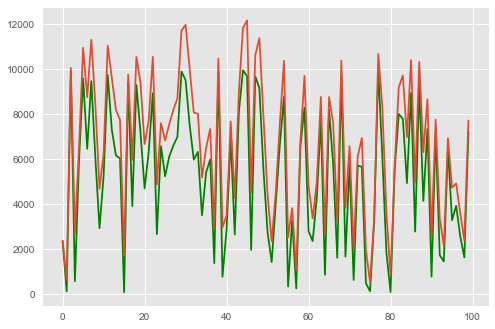

In [67]:
dot = carryover(arr.flatten(), strength=0.21, length=10)
plt.plot(arr, color='green');
plt.plot(dot.eval(), label=strength);

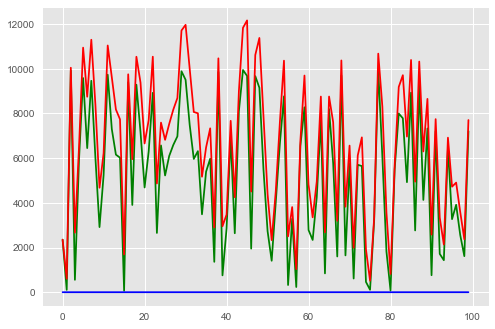

In [81]:
car_values = dot.eval()
sat = saturate(car_values, 0.000001)
plt.plot(arr, color='green');
plt.plot(dot.eval(), color='red');
plt.plot(sat.eval(), color='blue');

In [133]:
channel = "facebook"
coef_fb = initial_model.trace.posterior["coef_facebook_media_cost"].to_numpy().flatten()
sat_fb = initial_model.trace.posterior["sat_facebook_media_cost"].to_numpy().flatten()
car_fb = initial_model.trace.posterior["car_facebook_media_cost"].to_numpy().flatten()
values_fb = X["facebook_media_cost"].values

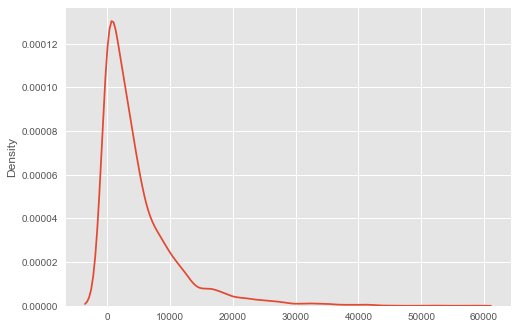

In [150]:
sns.kdeplot(coef_fb);

In [173]:
def carryover(x, strength, length=10):
    """
        same function as specified in google whitepaper
        usually use poission random variable for length
    """
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags), x_lags, w

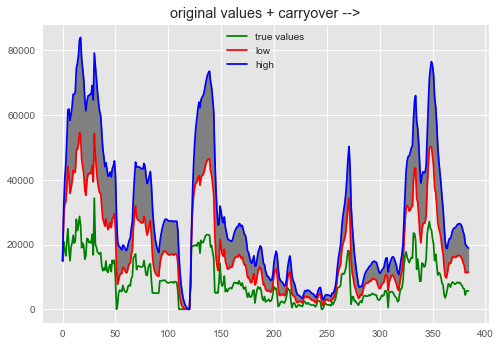

In [178]:
x = np.arange(len(values_fb))
plt.plot(x, values_fb, color='green', label="true values");
dot1, x_lags, w1 = carryover(values_fb, np.percentile(car_fb, 50))
dot2, x2_lags, w2 = carryover(values_fb, np.percentile(car_fb, 90))
plt.fill_between(x, dot1.eval(), dot2.eval(), color='grey')
plt.plot(x, dot1.eval(), color='red', label="low");
plt.plot(x, dot2.eval(), color='blue', label="high");
plt.legend();
plt.title("original values + carryover -->");

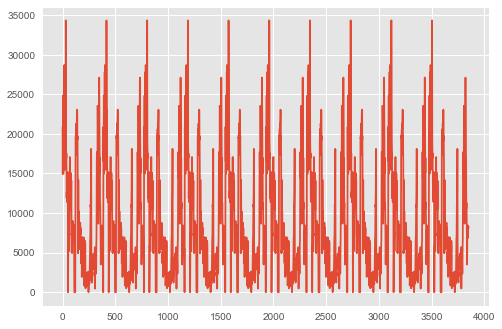

In [179]:
plt.plot(x_lags.eval().flatten());

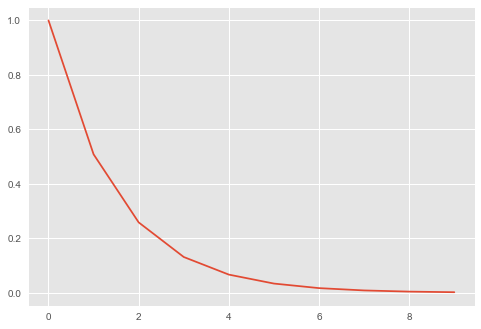

In [180]:
plt.plot(w1.eval().flatten());

In [147]:
values_fb_car = carryover(values_fb, np.mean(car_fb)).eval()

Text(0.5, 1.0, 'carryover + saturation --> orders')

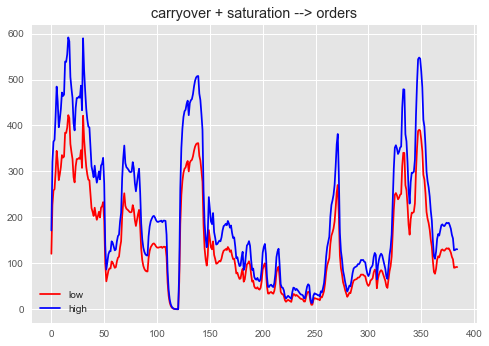

In [158]:
x = np.arange(len(values_fb_car))
dot1 = saturate(values_fb_car, np.percentile(sat_fb, 45))
dot2 = saturate(values_fb_car, np.percentile(sat_fb, 55))

plt.plot(x, coef_fb.mean() * dot1.eval(), color='red', label="low");
plt.plot(x, coef_fb.mean() * dot2.eval(), color='blue', label="high");
plt.legend();
plt.title("carryover + saturation --> orders");

In [163]:
np.percentile(coef_fb, 50)

2848.3930253525314

# OPTIMIZATION attempt-1

In [ ]:
def optimize_budget(model, budget=20000):
    
    num_media_vars = len(get_media_vars(data_matrix))
    var_names = model.feature_names_in_[:num_media_vars]
    num_vars = num_media_vars
    coef = model.coef_[:num_media_vars]
    vector = np.zeros(origdf.shape[1])
    carryover_vector = transform_row(vector, model, origdf).to_numpy()[:num_media_vars]
    constraint = LinearConstraint(np.ones(num_vars), lb=budget, ub=budget)
    
    bounds_from_slider = get_bound_vals(model, col_to_slider)
    
    bounds = [(bounds_from_slider[i][0], min(budget, bounds_from_slider[i][1])) for i in range(num_vars)]
    
    def objective_function(x, weights):
        
        powers = [float(extract_power(colName)) for colName in model.feature_names_in_]
        
        v = np.array([])
        for i, p in enumerate(powers):
            feature = model.feature_names_in_[i]
            orig_col, alpha, L, theta = re.findall("([\w|\s]+)_alpha=(\d.\d+)L=(\d+)theta=(\d+)", feature)[0]
            m = delayed_adstock(alpha=float(alpha), L=int(L), theta=int(theta))[0]
            temp = carryover_vector[i] + m * x[i]
            term = np.power(temp, p)

            v = np.append(v, term)
        return -1 * v.dot(weights)
    
    res = minimize(
    objective_function, method="SLSQP",
    x0 = budget * np.random.random(num_vars),
    args=(coef),
    constraints=constraint,
    bounds=bounds)
    
    print(f"Budget = ${budget}, Expected Revenue/Orders = {-1 * res.fun}")
    optimized_budget = dict(zip(var_names, res.x))
    return optimized_budget

In [196]:
t = initial_model.X.iloc[-10:, :]

<module 'datetime' from 'C:\\Users\\Rishab\\anaconda3\\lib\\datetime.py'>

In [203]:
t.loc[t.index[-1]+datetime.timedelta(days=1)] = 0
t

,amazon_media_cost,facebook_media_cost,youtube_media_cost,googlesearch_media_cost,dv360_media_cost
Day,,,,,
2022-01-31,0.0,15500.530003,0.0,4239.464944,0.0
2022-02-01,0.0,12032.780010,0.0,5569.117855,0.0
2022-02-02,0.0,8663.260010,0.0,6702.453279,0.0
2022-02-03,0.0,8677.630001,0.0,6859.368622,0.0
2022-02-04,0.0,14280.790004,0.0,6894.221412,0.0
2022-02-05,0.0,14015.460003,0.0,7869.858686,0.0
2022-02-06,0.0,13072.660000,0.0,8697.846211,0.0
2022-02-07,0.0,13290.980001,0.0,5909.458438,0.0
2022-02-08,0.0,15558.529999,0.0,6568.621366,0.0


In [184]:
def generate(model):
    """
        returns a single sample of the posterior
        for use in optimization
    """
    coef = []
    sat = []
    car = []
    
    sample_num = np.random.randint(low=0, high=999)
    
    for channel in model.feature_names_in_:
        
        posterior = model.trace.posterior
        coef.append(posterior[f"coef_{channel}"].to_numpy().mean(axis=0).flatten()[sample_num])
        sat.append(posterior[f"sat_{channel}"].to_numpy().mean(axis=0).flatten()[sample_num])
        car.append(posterior[f"car_{channel}"].to_numpy().mean(axis=0).flatten()[sample_num])
        
    return np.array(coef), np.array(sat), np.array(car)

def create_dataset_extra_rows(model):
    """
        returns a properly pre-processed dataset
        attaches past 10 rows from training dataset
        adds a dummy row at the bottom because last carryover doesn't matter
    """
    last_10_rows = model.X.iloc[-10:, :]   
    last_10_rows.loc[last_10_rows.index[-1] + datetime.timedelta(days=1)] = 0
    return last_10_rows

def calculate_carryover_vector(model, car, last_10_rows):
    """
    calculates carryover vector by iterating over each channel, and running carryover on each channel given the sampled car value
    """
    for channel in model.feature_names_in_:
        

In [ ]:
def objective_function(x, coef, sat, car, carryover_vector):
    """
        this is after values are sampled from the posterior
        x is an array of raw spends
        coef, sat, car, carryover should be vectors of length c where c = number of channels
        carryover should contain the carryover from past (10) days
        
        all should be numpy arrays
    """
    c = len(coef)
    # create matrix of coefficients for final step
    weights = np.eye(c) @ coef
    
    # assuming we pre-compute carryovers so we can exclude from objective fn
    # note: there is no loss at day-0 of spends
    spends = carryover_vector + x
    
    # applies saturation curve on carryover'd spend
    sats = np.eye(c) @ np.array(sat)
    
    return weights@(1 - np.exp(-sats@spends))

res = minimize(
    objective_function, method="SLSQP",
    x0 = budget * np.random.random(num_vars),
    args=(coef),
    constraints=constraint,
    bounds=bounds)

# Forecasting

In [22]:
X.columns

Index(['amazon_media_cost', 'facebook_media_cost', 'youtube_media_cost'], dtype='object')

To forecast for one-month (or any time length greater than 1 day), write an excel spreadsheet or .csv file with the above columns in that **EXACT** order. Set `use_excel` to `True` if the file is an excel file, else set it to `False`.

In [23]:
data_type = "ad data [forecasting]"
use_excel = True

In [24]:
forecast_as_bytes = input_file(data_type, use_excel=use_excel)

FileUpload(value={}, accept='.xlsx', description='Upload')

In [26]:
forecast_sales_df = parse_file(forecast_as_bytes, data_type, use_excel=use_excel)

Thanks for uploading the ad data [forecasting]. I will display the dataframe in 2 seconds


,amazon,facebook,youtube
0,10000,10000,10000
1,10000,10000,10000
2,10000,10000,10000
3,10000,10000,10000
4,10000,10000,10000


Is the header correct [y/n] y


SUCCESS -- PROCEED


In [27]:
forecast_sales_df = forecast_sales_df.iloc[:, np.arange(len(get_media_vars(X)))]
forecast_sales_df.columns = get_media_vars(X)

In [28]:
forecast_output_df = month_predict(forecast_sales_df.copy(), data_dict[country].copy(), initial_model, "additive")

KeyError: "None of [Index(['amazon_media_cost', 'facebook_media_cost', 'youtube_media_cost'], dtype='object')] are in the [columns]"